## simulation results
achen@2021-5-23

In [1]:
workdir = '/data1/chenyaowen/workspace/metaSNP_finalversion/simulation/'

In [2]:
import pandas as pd
import os
import glob
from Bio import Seq
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import re
from scipy.stats import wilcoxon,mannwhitneyu
import numpy as np
import pysam

In [3]:
import dask.dataframe as dd
from dask import delayed
def read_and_label_csv(filename):
    df_csv = pd.read_csv(filename,dtype={'best_mean_nm':str})
    df_csv['filename'] = os.path.basename(filename).replace('.csv','')
    return df_csv

In [4]:
fnames = glob.glob(f'{workdir}/res/*.csv')
dfs = [delayed(read_and_label_csv)(fname) for fname in fnames]
df = dd.from_delayed(dfs)

In [5]:
df = df.compute()

In [57]:
df = df[df['frac']>0]

In [58]:
df.head()

,Unnamed: 0,name,real_cov,real_dep,frac,rank,predicted_cov,predicted_dep,best_mean_nm,filename
0,0,GCA_003287475.1_ASM328747v1_genomic,0.780705,7.377703,0.155172,1,80.910130,7.813500,0.00010094433424687957,4a9026f5-afec-4637-aef5-4efb9d012ed0
1,1,GCA_014868915.1_ASM1486891v1_genomic,0.940908,7.531915,0.137931,0,94.173239,7.877173,5.759705103098721e,4a9026f5-afec-4637-aef5-4efb9d012ed0
2,2,GCA_009679995.1_ASM967999v1_genomic,0.618230,4.551295,0.086207,2,68.993906,5.658785,0.0007968624407550098,4a9026f5-afec-4637-aef5-4efb9d012ed0
3,3,GCA_003287415.1_ASM328741v1_genomic,0.626931,4.302776,0.068966,12,64.203637,4.770463,0.0006328570815634788,4a9026f5-afec-4637-aef5-4efb9d012ed0
0,0,GCA_014869135.1_ASM1486913v1_genomic,0.112220,0.328628,0.004577,10,11.421760,0.330922,0.0,1c639a39-49af-4d3f-8d6f-8adbff361ed3


In [13]:
count_dict = {}
for f in glob.glob(f'{workdir}/info/*.info'):
    uui = os.path.basename(f).replace('.info','')
    count = 0
    with open(f,'r') as inpf:
        for line in inpf:
            line = line.strip()
            count = int(line[1:])
            break
    count_dict[uui] = count

In [ ]:
import gzip
real_count = {}
strain_count = {}
for f in df.filename.unique():
    print(f)
    with gzip.open(f'../simulation/data/{f}_1.fastq.gz','rb') as inpf:
        i = -1
        for line in inpf:
            i += 1
            if i%4 == 0:
                line = line.decode('utf-8')
                genome = '-'.join(line[1:].split('-')[:-1])
                if f not in strain_count:
                    strain_count[f] = {}
                strain_count[f][genome] = strain_count[f].get(genome,0)+ 1
                real_count[f] = real_count.get(f,0) + 1

In [86]:
genomeInfo = pd.read_csv('../refs/136Fstrains/datalist.csv',sep='\t')
genomeSize = dict(genomeInfo.set_index("Assembly")['Size(Mb)'])

In [122]:
predicted_abun_dict = {}
for f in df['filename'].unique():
    #total = count_dict[f]
    total = real_count[f]
    tmpdf = pd.read_csv(f'{workdir}/stats/stat.{f}.csv')
    tmpdf['ref'] = 'GCA' + tmpdf['src'].str.split('GCA').str[-1]
    tmpdf['genome'] = ['_'.join(x.split('_')[:2]) for x in tmpdf['ref']]
    tmpdf['best'] = tmpdf['best']/(tmpdf['genome'].map(genomeSize))
    tmpdf['best'] = tmpdf['best']/total
    predicted_abun_dict[f] = dict(tmpdf.set_index('ref')['best'])

In [166]:
predicted_abuns = []
actual_abuns = []
for index,row in df.iterrows():
    f = row['filename']
    genome = row['name']
    predicted_abun = predicted_abun_dict[f][genome]
    #actual_abun = row['frac']
    actual_abun = strain_count[f][genome]/(real_count[f]*genomeSize['_'.join(genome.split('_')[:2])])
    actual_abun = actual_abun * 2  # pair-end reads
    predicted_abuns.append(predicted_abun)
    actual_abuns.append(actual_abun)

In [167]:
df['predicted_abun'] = predicted_abuns
df['real_abun'] = actual_abuns

In [170]:
df['predicted_cov'] = df['predicted_cov']/100

<AxesSubplot:xlabel='Actual coverage', ylabel='Estimated coverage'>

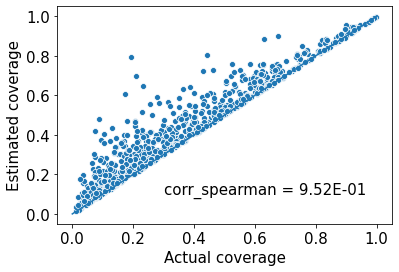

In [325]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df,x='real_cov',y='predicted_cov')
plt.xlabel('Actual coverage',fontsize=15)
plt.ylabel('Estimated coverage',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

corr,pval = spearmanr(df['real_cov'],df['predicted_cov'])
plt.text(0.3,0.1,f'corr_spearman = {corr:.2E}',fontsize=15)

sns.lineplot([0,1],[0,1])

<AxesSubplot:xlabel='Actual depth', ylabel='Estimated depth'>

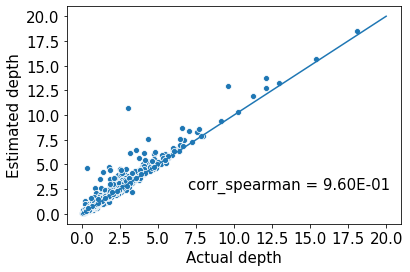

In [344]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df,x='real_dep',y='predicted_dep')

plt.xlabel('Actual depth',fontsize=15)
plt.ylabel('Estimated depth',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

corr,pval = spearmanr(df['real_dep'],df['predicted_dep'])
plt.text(7,2.5,f'corr_spearman = {corr:.2E}',fontsize=15)

sns.lineplot([0,20],[0,20])

<AxesSubplot:xlabel='Actual abundance', ylabel='Estimated abundance'>

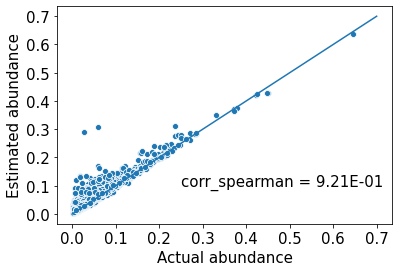

In [347]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df,x='real_abun',y='predicted_abun')

plt.xlabel('Actual abundance',fontsize=15)
plt.ylabel('Estimated abundance',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

corr,pval = spearmanr(df['real_abun'],df['predicted_abun'])
plt.text(0.25,0.1,f'corr_spearman = {corr:.2E}',fontsize=15)

sns.lineplot([0,0.7],[0,0.7])